In [34]:
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.spatial.distance import pdist, squareform

In [35]:
def display_scaled(pic, scale=1):
    h, w = pic.shape[:2]
    display(Image.fromarray(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)).resize((int(w * scale), int(h * scale)), Image.LANCZOS))

In [36]:
def show_gray_hist(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).ravel()
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.plot(hist)
    plt.xlim([0, 255])
    plt.show()

In [37]:
def process_references(ref_dir, verbose = 0):
    
    #sift = cv2.SIFT_create(contrastThreshold=0.01, edgeThreshold=12, nOctaveLayers=8, sigma=1.5)
    sift = cv2.SIFT_create()
    ref_data = []

    for file in Path(ref_dir).rglob("*"):
        
        if not file.is_file():
            continue
        
        card_to_search_color = cv2.imread(str(file))

        if card_to_search_color is None:
            continue
        if verbose > 2: display_scaled(card_to_search_color, 0.5)

        card_to_search_gray = cv2.cvtColor(card_to_search_color, cv2.COLOR_BGR2GRAY)
        if verbose > 2: display_scaled(card_to_search_gray, 0.5)
        if verbose > 3: show_gray_hist(card_to_search_gray)

        _, card_to_search_thresh = cv2.threshold(card_to_search_gray, 150, 255, cv2.THRESH_BINARY)
        card_to_search_masked = cv2.bitwise_and(card_to_search_gray, card_to_search_gray, mask=card_to_search_thresh)
        if verbose > 2: display_scaled(card_to_search_masked, 0.5)
        if verbose > 3: show_gray_hist(card_to_search_masked)

        ref_kp, ref_des = sift.detectAndCompute(card_to_search_masked, None)
        if verbose > 0: print(f'{str(file)} -> {len(ref_kp)} key-points found')

        ref_kp_img = cv2.drawKeypoints(card_to_search_color, ref_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        if verbose > 1: display_scaled(ref_kp_img, 0.5)

        card_face = file.name.split(".")[0]
        ref_data.append((card_face, ref_kp, ref_des, card_to_search_color))
    
    return ref_data

In [38]:
def process_image(img_name, verbose=0):

    #sift = cv2.SIFT_create(contrastThreshold=0.01, edgeThreshold=12, nOctaveLayers=8, sigma=1.5)
    sift = cv2.SIFT_create()

    img_to_process_color = cv2.imread(img_name)
    if verbose > 2: display_scaled(img_to_process_color, 0.2)

    img_to_process_gray = cv2.cvtColor(img_to_process_color, cv2.COLOR_BGR2GRAY)
    if verbose > 2: display_scaled(img_to_process_gray, 0.2)
    if verbose > 3: show_gray_hist(img_to_process_gray)

    _, img_to_process_thresh = cv2.threshold(img_to_process_gray, 150, 255, cv2.THRESH_BINARY)
    img_to_process_masked = cv2.bitwise_and(img_to_process_gray, img_to_process_gray, mask=img_to_process_thresh)
    if verbose > 2: display_scaled(img_to_process_masked, 0.2)
    if verbose > 3: show_gray_hist(img_to_process_masked)
    
    kp, des = sift.detectAndCompute(img_to_process_masked, None)

    if verbose > 0: print(f'{len(kp)} key-points found in {img_name}')

    kp_img = cv2.drawKeypoints(img_to_process_color, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    if verbose > 1: display_scaled(kp_img, 0.2)

    edges = cv2.Canny(img_to_process_masked, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return kp, des, img_to_process_color, img_to_process_masked, contours

In [39]:
def get_matches(des_reference, des_image, distance_ratio=0.75, verbose=0):
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = matcher.knnMatch(des_reference, des_image, k=2)
    good_matches = [m for m, n in matches if m.distance < distance_ratio * n.distance]
    
    if verbose > 0: print(f"{len(good_matches)} good matches out of {len(matches)} total matches")
    
    return matches, good_matches

In [40]:
from os import name


def findHomography(src_pts, dst_pts):
    M1, mask1 = cv2.estimateAffine2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=3.0, maxIters=50000, confidence=0.995)
    M1 = np.vstack([M1, [0, 0, 1]])
    name = "estimateAffine2D (RANSAC)"
    ret_M = M1
    ret_mask = mask1

    M2, mask2 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0, maxIters=50000, confidence=0.995)
    if np.sum(mask2) > np.sum(ret_mask):
        name = "findHomography (RANSAC)"
        ret_M = M2
        ret_mask = mask2

    M3, mask3 = cv2.findHomography(src_pts, dst_pts, cv2.USAC_ACCURATE, 3.0, maxIters=50000, confidence=0.995)
    if np.sum(mask3) > np.sum(ret_mask):
        name = "findHomography (USAC_ACCURATE)"
        ret_M = M3
        ret_mask = mask3

    return name, ret_M, ret_mask

In [41]:
def find_cards(reference_card_data, kp, des, distance_ratio = 0.75, verbose=0):

    found = []

    for ref_name, ref_kp, ref_des, ref_img_color in reference_card_data:
        if verbose > 0: print(f"processing {ref_name}...")

        matches, good_matches = get_matches(ref_des, des, distance_ratio=distance_ratio, verbose=verbose)
        
        if len(good_matches) >= 8:
            if verbose > 0: print(f'{len(good_matches)} out of {len(matches)} is {len(good_matches) / len(matches)} rate')

            src_pts = np.float32([ref_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            if verbose > 0: print(f"trying to match src_pts.shape={src_pts.shape} dst_pts.shape={dst_pts.shape}")

            h, w = ref_img_color.shape[:2]
            pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
            name, M, mask = findHomography(src_pts, dst_pts)
            if verbose > 0: print(f"{name} found {np.sum(mask)} inliers out of {len(good_matches)} good matches")
            dst = cv2.perspectiveTransform(pts, M)
            found.append((ref_name, name, dst, np.sum(mask), len(good_matches), len(matches)))
    
    return found

In [42]:
def calculate_side_lengths(corners):
    corners = np.squeeze(corners)
    side_lengths = []

    for i in range(4):
        point1 = corners[i]
        point2 = corners[(i + 1) % 4]
        length = np.linalg.norm(point2 - point1)
        side_lengths.append(length)

    shortest = min(side_lengths)
    longest = max(side_lengths)
    aspect = longest / shortest

    return side_lengths, aspect

In [43]:
def group_by_centroid_proximity(quads, threshold=50):
    centroids = np.array([quad.reshape(4, 2).mean(axis=0) for quad in quads])
    distances = squareform(pdist(centroids))
   
    n = len(quads)
    group_labels = -np.ones(n, dtype=int)
    group_id = 0
    
    for i in range(n):
        if group_labels[i] != -1:
            continue
        group_labels[i] = group_id
        for j in range(i + 1, n):
            if distances[i, j] < threshold:
                group_labels[j] = group_id
        group_id += 1
        
    return group_labels

In [44]:
def refine_found_data(found_data, img_to_process_color, verbose=0):
    refined = {}
    refined_final = {}
    ret = []

    for ref_name, hname, dst, l_mask, l_good_matches, l_matches in found_data:
        h, w = img_to_process_color.shape[:2]

        if cv2.isContourConvex(dst) == False:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: not convex")
            continue

        if cv2.contourArea(dst) < h*w*0.01 or cv2.contourArea(dst) > h*w*0.8:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: area={cv2.contourArea(dst)} (full is {h*w})")
            continue

        if l_mask < 6 and l_mask/l_good_matches < 0.1:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: {l_mask} inliers {l_mask/l_good_matches} {l_good_matches/l_matches} ")
            continue

        if any(dst[dst<0]) or any(dst[:, :, 0] > w) or any(dst[:, :, 1] > h):
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: dst={dst} out of bounds")
            continue

        _, aspect = calculate_side_lengths(dst)
        if aspect > 2:
            if verbose > 0: print(f"DROP {ref_name} with {hname} dropped: aspect={aspect} too long")
            continue
        
        if verbose > 0: print(f"{ref_name} with {hname} found {l_mask} inliers out of {l_good_matches} good matches out of {l_matches} total matches -> area={cv2.contourArea(dst)} (full is {h*w})")
        
        if ref_name not in refined.keys():
            refined[ref_name] = {'min_dst': dst, 'score': l_good_matches}
        else:
            if l_good_matches > refined[ref_name]['score']:
                refined[ref_name]['score'] = l_good_matches
            if cv2.contourArea(dst) < cv2.contourArea(refined[ref_name]['min_dst']):
                refined[ref_name]['min_dst'] = dst

    all_dst = []
    for ref in refined:
        all_dst.append(refined[ref]['min_dst'])

    groups = group_by_centroid_proximity(all_dst, threshold=200)
    if verbose > 0: print(f"there are {len(groups)} groups of possible cards")

    for ref, grp in zip(refined.keys(), groups):
        refined[ref]['group'] = grp

    for ref in refined:
        grp = refined[ref]['group']
        if grp not in refined_final.keys():
            if verbose > 0: print(f'adding {grp} group with {ref}')
            refined_final[refined[ref]['group']] = {'min_dst': refined[ref]['min_dst'], 'score': refined[ref]['score'], 'face': ref}
        else:
            if refined[ref]['score'] > refined_final[grp]['score']:
                if verbose > 0: print(f'modifying {grp} group -> new face {ref}')
                refined_final[refined[ref]['group']] = {'min_dst': refined[ref]['min_dst'], 'score': refined[ref]['score'], 'face': ref}

    for key, value in refined_final.items():
        ret.append((value['min_dst'].squeeze(axis=1), value['face'], value['score']))

    return ret

In [45]:
def poly_area_signed(pts):
    x, y = pts[:, 0], pts[:, 1]
    return 0.5 * np.sum(x * np.roll(y, -1) - y * np.roll(x, -1))

In [46]:
def display_annotated_image(img, quads, color=(0, 255, 0), thickness=2):
    annotated = img.copy()

    for quad in quads:
        cv2.polylines(
            annotated,
            [quad.astype(np.int32)],
            isClosed=True,
            color=color,
            thickness=thickness,
            lineType=cv2.LINE_AA
        )

    display_scaled(annotated, 0.25)

In [47]:
def get_quads(cntrs, img_to_process_color, verbose=0):
    quads      = []
    all_polys  = []
    MIN_AREA_RATIO = 0.01
    ASPECT_LOW, ASPECT_HIGH = 0.333, 3.0
    RECT_FILL_RATIO = 0.0001

    h, w = img_to_process_color.shape[:2]
    img_area = h * w

    for c in cntrs:
        eps  = 0.015 * cv2.arcLength(c, True)
        poly = cv2.approxPolyDP(c, eps, True)

        all_polys.append(poly)
            
        if 4 < len(poly) <= 8:
            hull = cv2.convexHull(poly)
            peri_h = cv2.arcLength(hull, True)
            poly_h = cv2.approxPolyDP(hull, 0.04 * peri_h, True)
            if len(poly_h) != 4:
                continue
            else:
                poly = poly_h

        if len(poly) != 4 or not cv2.isContourConvex(poly):
            continue
        
        quad = poly.reshape(4, 2).astype(np.float32)
        w_top = np.linalg.norm(quad[1] - quad[0])
        w_bot = np.linalg.norm(quad[2] - quad[3])
        h_left = np.linalg.norm(quad[0] - quad[3])
        h_right= np.linalg.norm(quad[2] - quad[1])
        shortest = min(h_left, h_right, w_top, w_bot)
        longest  = max(h_left, h_right, w_top, w_bot)
        if longest / shortest > ASPECT_HIGH:
            continue
        width = max(w_top, w_bot)
        height = max(h_left, h_right)
        aspect = width / height if height else 0

        if not (ASPECT_LOW <= aspect <= ASPECT_HIGH):
            continue
    
        if cv2.contourArea(quad) < MIN_AREA_RATIO * img_area:
            continue
        
        if cv2.contourArea(c) / cv2.contourArea(quad) < RECT_FILL_RATIO:
            continue

        quads.append(quad)

    final_quads = []
    mpa = np.mean([abs(poly_area_signed(quad)) for quad in quads])
    for quad in quads:
        if abs(poly_area_signed(quad)) < mpa * 2:
            final_quads.append(quad)

    if verbose > 0: print(f"found {len(final_quads)} quads")
    if verbose > 1:
        display_annotated_image(img_to_process_color, quads, thickness=20)
 
    return final_quads, all_polys

In [48]:
def order_ccw(pts):
    c = pts.mean(axis=0)
    angles = np.arctan2(pts[:, 1] - c[1], pts[:, 0] - c[0])
    pts = pts[np.argsort(angles)]
    tl_idx = np.argmin(pts.sum(axis=1))
    return np.roll(pts, -tl_idx, axis=0).astype(np.float32)

In [49]:
def warp_image(img, quad):
    quad = order_ccw(quad)

    wA = np.linalg.norm(quad[1] - quad[0])
    wB = np.linalg.norm(quad[2] - quad[3])
    hA = np.linalg.norm(quad[3] - quad[0])
    hB = np.linalg.norm(quad[2] - quad[1])

    width  = int(round(max(wA, wB)))
    height = int(round(max(hA, hB)))

    dst = np.array([[0, 0],
                    [width - 1, 0],
                    [width - 1, height - 1],
                    [0, height - 1]], np.float32)

    if poly_area_signed(quad) * poly_area_signed(dst) < 0:
        dst = dst[::-1]

    H = cv2.getPerspectiveTransform(quad, dst)
    warped = cv2.warpPerspective(img, H, (width, height),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REPLICATE)


    if warped.shape[0] > warped.shape[1]:
        warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)

    return warped

In [50]:
def scale_image(img, w, h):
    interp = cv2.INTER_LANCZOS4
    return cv2.resize(img, (w, h), interpolation=interp)

In [51]:
def process_quads(image, quads, ref_data, dist_ratio, verbose=0):

    per_card_data = []
    #sift = cv2.SIFT_create(contrastThreshold=0.05, edgeThreshold=15, nOctaveLayers=6, sigma=1.1)
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    for quad in quads:
        warped = warp_image(image, quad)
        blurred = cv2.GaussianBlur(warped, (11, 11), 0)
        gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
        mask = cv2.bitwise_and(gray, gray, mask=thresh)

        if verbose > 2: display_scaled(mask, 0.5)

        kp, des = sift.detectAndCompute(mask, None)
        if verbose > 0: print(f"{len(kp):4d} key-points")
        if verbose > 1: 
            ref_kp_img = cv2.drawKeypoints(mask, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)        
            display_scaled(ref_kp_img, 0.5)

        best_ref, best_score = None, 0

        for name, kp_ref, des_ref, _ in ref_data:
            knn = bf.knnMatch(des, des_ref, k=2)
            good = [m for m, n in knn if m.distance < dist_ratio * n.distance]
            if len(good) > best_score:
                best_ref, best_score = name, len(good)

        if best_ref is None:
            per_card_data.append((quad, 'no reasonable match', best_score))
            if verbose > 0: print(f"no reasonable match")
        else:
            per_card_data.append((quad, best_ref, best_score))
            if verbose > 0: print(f"best match → {best_ref}  ({best_score} good matches)")

    return per_card_data

In [52]:
def merge_results(per_card_data, refined_found_data):
    merged_data = per_card_data + refined_found_data
    retset = {}
    ret = []

    all_quads = []
    for quad, face, _ in merged_data:
        all_quads.append(quad)
    groups = group_by_centroid_proximity(all_quads, threshold=200)

    for (quad, face, inliners), group in zip(merged_data, groups):
        if group not in retset.keys():
            retset[group] = [quad, face, inliners, None]
        else:
            if inliners > retset[group][2]:
                retset[group] = [quad, face, inliners, retset[group][1]]

    for key, value in retset.items():
        ret.append((value[0], value[1], value[2], value[3]))

    return ret

In [53]:
REFERENCES_DIR = "references3"
reference_card_data = process_references("references3/", verbose=0)

In [54]:
TEST_IMG_NAME = "pics2/test_image - 2.jpeg"
kp, des, img_to_process_color, img_to_process_masked, contours = process_image(TEST_IMG_NAME, verbose=0)

In [55]:
quads, all_polys = get_quads(contours, img_to_process_color, verbose=0)

In [56]:
DIST_RATIO = 0.6
per_card_data = process_quads(img_to_process_color, quads, reference_card_data, DIST_RATIO, verbose=0)

In [57]:
DISTANCE_RATIO = 0.8
found_data = find_cards(reference_card_data, kp, des, distance_ratio=DISTANCE_RATIO, verbose=0)
#matches_img = cv2.drawMatches(ref_img_color, ref_kp, img_to_process_color, kp, good_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

In [58]:
refined_found_data = refine_found_data(found_data, img_to_process_color, verbose=0)

In [59]:
merged_result = merge_results(per_card_data, refined_found_data)

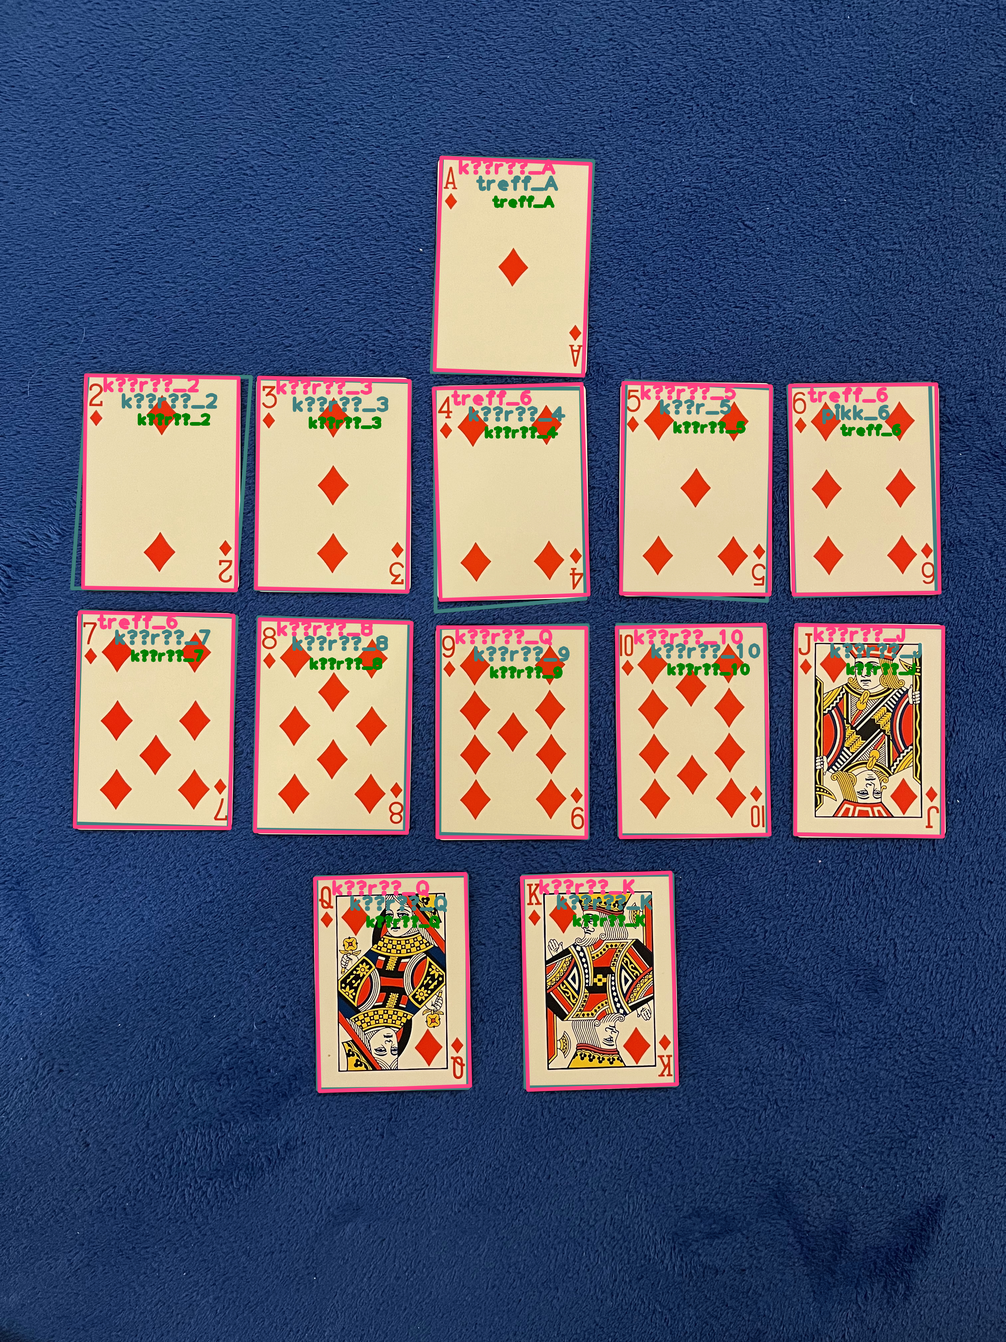

In [62]:
result_img_annotated = img_to_process_color.copy()

for quad, face, score, face2 in merged_result:
    result_img_annotated = cv2.polylines(result_img_annotated, [np.int32(quad)], True, (0, 128, 0), 10, cv2.LINE_AA)
    cv2.putText(result_img_annotated, f"{face}", tuple(np.int32(order_ccw(quad)[0])+150), cv2.FONT_HERSHEY_PLAIN, 3, (0, 128, 0), 10)


for quad, face, _ in refined_found_data:
    result_img_annotated = cv2.polylines(result_img_annotated, [np.int32(quad)], True, (128, 128, 64), 10, cv2.LINE_AA)
    cv2.putText(result_img_annotated, face, tuple(np.int32(order_ccw(quad)[0])+100), cv2.FONT_HERSHEY_PLAIN, 4, (128, 128, 64), 10)

for quad, face, _ in per_card_data:
    result_img_annotated = cv2.polylines(result_img_annotated, [np.int32(quad)], True, (128, 64, 255), 10, cv2.LINE_AA)
    if face != 'no reasonable match':
        cv2.putText(result_img_annotated, face, tuple(np.int32(order_ccw(quad)[0])+50), cv2.FONT_HERSHEY_PLAIN, 4, (128, 64, 255), 10)

display_scaled(result_img_annotated, 0.333)